In [ ]:
!pip install playsound

In [ ]:
import dlib
import sys
import cv2
import time
import numpy as np
from scipy.spatial import distance as dist
from threading import Thread
import playsound
#import Queue as queue

import queue
#import Queue
# from light_variability import adjust_gamma

FACE_DOWNSAMPLE_RATIO = 1.5
RESIZE_HEIGHT = 460

thresh = 0.27
modelPath = "models/shape_predictor_70_face_landmarks.dat"
sound_path = "alarm.wav"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)
modelPath = "models/shape_predictor_68_face_landmarks.dat"


leftEyeIndex = [36, 37, 38, 39, 40, 41]
rightEyeIndex = [42, 43, 44, 45, 46, 47]

blinkCount = 0
drowsy = 0
state = 0
blinkTime = 0.15 #150ms
drowsyTime = 1.5  #1200ms
ALARM_ON = False
GAMMA = 1.5
threadStatusQ = queue.Queue()

invGamma = 1.0/GAMMA
table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(0, 256)]).astype("uint8")

def gamma_correction(image):
    return cv2.LUT(image, table)

def histogram_equalization(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.equalizeHist(gray) 

def soundAlert(path, threadStatusQ):
    while True:
        if not threadStatusQ.empty():
            FINISHED = threadStatusQ.get()
            if FINISHED:
                break
        playsound.playsound(alarm.wav)
        

def soundAlert(alarmPath, drowsyStatus):
    
    while drowsyStatus == 1 :
        playsound.playsound(alarmPath)
        
        
        

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3
                                  ])
    ear = (A + B) / (2.0 * C)

    return ear


def checkEyeStatus(landmarks):
    mask = np.zeros(frame.shape[:2], dtype = np.float32)
    
    hullLeftEye = []
    for i in range(0, len(leftEyeIndex)):
        hullLeftEye.append((landmarks[leftEyeIndex[i]][0], landmarks[leftEyeIndex[i]][1]))

    cv2.fillConvexPoly(mask, np.int32(hullLeftEye), 255)

    hullRightEye = []
    for i in range(0, len(rightEyeIndex)):
        hullRightEye.append((landmarks[rightEyeIndex[i]][0], landmarks[rightEyeIndex[i]][1]))


    cv2.fillConvexPoly(mask, np.int32(hullRightEye), 255)

    # lenLeftEyeX = landmarks[leftEyeIndex[3]][0] - landmarks[leftEyeIndex[0]][0]
    # lenLeftEyeY = landmarks[leftEyeIndex[3]][1] - landmarks[leftEyeIndex[0]][1]

    # lenLeftEyeSquared = (lenLeftEyeX ** 2) + (lenLeftEyeY ** 2)
    # eyeRegionCount = cv2.countNonZero(mask)

    # normalizedCount = eyeRegionCount/np.float32(lenLeftEyeSquared)

    #############################################################################
    leftEAR = eye_aspect_ratio(hullLeftEye)
    rightEAR = eye_aspect_ratio(hullRightEye)

    ear = (leftEAR + rightEAR) / 2.0
    #############################################################################

    eyeStatus = 1          # 1 -> Open, 0 -> closed
    if (ear < thresh):
        eyeStatus = 0

    return eyeStatus  

def checkBlinkStatus(eyeStatus):
    global state, blinkCount, drowsy
    if(state >= 0 and state <= falseBlinkLimit):
        if(eyeStatus):
            state = 0

        else:
            state += 1

    elif(state >= falseBlinkLimit and state < drowsyLimit):
        if(eyeStatus):
            blinkCount += 1 
            state = 0

        else:
            state += 1


    else:
        if(eyeStatus):
            state = 0
            drowsy = 1
            blinkCount += 1

        else:
            drowsy = 1

def getLandmarks(im):
    imSmall = cv2.resize(im, None, 
                            fx = 1.0/FACE_DOWNSAMPLE_RATIO, 
                            fy = 1.0/FACE_DOWNSAMPLE_RATIO, 
                            interpolation = cv2.INTER_LINEAR)

    rects = detector(imSmall, 0)
    if len(rects) == 0:
        return 0

    newRect = dlib.rectangle(int(rects[0].left() * FACE_DOWNSAMPLE_RATIO),
                            int(rects[0].top() * FACE_DOWNSAMPLE_RATIO),
                            int(rects[0].right() * FACE_DOWNSAMPLE_RATIO),
                            int(rects[0].bottom() * FACE_DOWNSAMPLE_RATIO))

    points = []
    [points.append((p.x, p.y)) for p in predictor(im, newRect).parts()]
    return points

capture = cv2.VideoCapture(0)

for i in range(10):
    ret, frame = capture.read()

totalTime = 0.0
validFrames = 0
dummyFrames = 100

print("Caliberation in Progress!")
while(validFrames < dummyFrames):
    validFrames += 1
    t = time.time()
    ret, frame = capture.read()
    height, width = frame.shape[:2]
    IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
    frame = cv2.resize(frame, None, 
                        fx = 1/IMAGE_RESIZE, 
                        fy = 1/IMAGE_RESIZE, 
                        interpolation = cv2.INTER_LINEAR)

    # adjusted = gamma_correction(frame)
    adjusted = histogram_equalization(frame)

    landmarks = getLandmarks(adjusted)
    timeLandmarks = time.time() - t

    if landmarks == 0:
        validFrames -= 1
        cv2.putText(frame, "Unable to detect face, Please check proper lighting", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, "or decrease FACE_DOWNSAMPLE_RATIO", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.imshow("Blink Detection Demo", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            sys.exit()

    else:
        totalTime += timeLandmarks
        # cv2.putText(frame, "Caliberation in Progress", (200, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        # cv2.imshow("Blink Detection Demo", frame)
        
    # if cv2.waitKey(1) & 0xFF == 27:
    #         sys.exit()

print("Caliberation Complete!")

spf = totalTime/dummyFrames
print("Current SPF (seconds per frame) is {:.2f} ms".format(spf * 1000))

drowsyLimit = drowsyTime/spf
falseBlinkLimit = blinkTime/spf
print("drowsy limit: {}, false blink limit: {}".format(drowsyLimit, falseBlinkLimit))

if __name__ == "__main__":
    vid_writer = cv2.VideoWriter('output-low-light-2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (frame.shape[1],frame.shape[0]))
    while(1):
        try:
            t = time.time()
            ret, frame = capture.read()
            height, width = frame.shape[:2]
            IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
            frame = cv2.resize(frame, None, 
                                fx = 1/IMAGE_RESIZE, 
                                fy = 1/IMAGE_RESIZE, 
                                interpolation = cv2.INTER_LINEAR)

            # adjusted = gamma_correction(frame)
            adjusted = histogram_equalization(frame)

            landmarks = getLandmarks(adjusted)
            if landmarks == 0:
                validFrames -= 1
                cv2.putText(frame, "Unable to detect face, Please check proper lighting", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                cv2.putText(frame, "or decrease FACE_DOWNSAMPLE_RATIO", (10, 50), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                cv2.imshow("Blink Detection Demo", frame)
                if cv2.waitKey(1) & 0xFF == 27:
                    break
                continue

            eyeStatus = checkEyeStatus(landmarks)
            checkBlinkStatus(eyeStatus)

            for i in range(0, len(leftEyeIndex)):
                cv2.circle(frame, (landmarks[leftEyeIndex[i]][0], landmarks[leftEyeIndex[i]][1]), 1, (0, 0, 255), -1, lineType=cv2.LINE_AA)

            for i in range(0, len(rightEyeIndex)):
                cv2.circle(frame, (landmarks[rightEyeIndex[i]][0], landmarks[rightEyeIndex[i]][1]), 1, (0, 0, 255), -1, lineType=cv2.LINE_AA)

            if drowsy:
                cv2.putText(frame, "! ! ! DROWSINESS ALERT ! ! !", (70, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                if not ALARM_ON:
                    ALARM_ON = True
                    threadStatusQ.put(not ALARM_ON)
                    thread = Thread(target=soundAlert, args=(sound_path, threadStatusQ,))
                    thread.setDaemon(True)
                    thread.start()

            else:
                cv2.putText(frame, "Blinks : {}".format(blinkCount), (460, 80), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,0,255), 2, cv2.LINE_AA)
                # (0, 400)
                ALARM_ON = False


            cv2.imshow("Blink Detection Demo", frame)
            vid_writer.write(frame)

            k = cv2.waitKey(1) 
            if k == ord('r'):
                state = 0
                drowsy = 0
                ALARM_ON = False
                threadStatusQ.put(not ALARM_ON)

            elif k == 27:
                break

            # print("Time taken", time.time() - t)

        except Exception as e:
            print(e)

    capture.release()
    vid_writer.release()
    cv2.destroyAllWindows()

Caliberation in Progress!


In [3]:
!pip install mlxtend

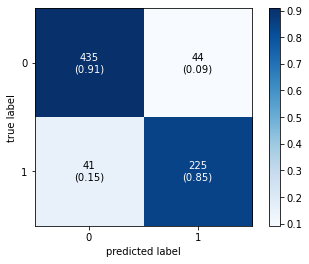

In [7]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary = np.array([[435, 44],
                   [41, 225]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()